#Import

In [76]:
!pip install tensorflow
!pip install tensorflowjs

In [77]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import NASNetMobile, InceptionV3, ResNet50, VGG16, Xception
from tensorflow.keras import layers, models
from tensorflow.keras.applications.nasnet import preprocess_input as nasnet_preprocess
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import json
import tensorflowjs as tfjs
from tensorflow.keras.models import load_model
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.applications import Xception
from tensorflow.keras.optimizers import Adam

In [78]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Load Dataset

In [79]:
!ls /content/drive/MyDrive/Image-Dea/Dataset\ TA/

'Agrotis Sp'   my_model.h5  'Phenacoccus Manihoti'  'Plutella Xylostella'  'Spodoptera Litura'


In [80]:
data_dir = '/content/drive/MyDrive/Image-Dea/Dataset TA/'

In [81]:
from PIL import Image

def verify_images(data_dir):
    """
    Verify all images in the dataset are valid (not corrupt).
    """
    for root, dirs, files in os.walk(data_dir):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = Image.open(file_path)
                img.verify()  # Just verify if the image is valid
            except (IOError, SyntaxError) as e:
                print(f"Bad file: {file_path}")  # Print the bad file path

# Call this function to verify your images
verify_images(data_dir)

#Preprocessing

In [82]:
# preprocessing_function=None,  # Xception does not need additional preprocessing_function
datagen = ImageDataGenerator(
    preprocessing_function= xception_preprocess,
      rescale=1./255,  # Rescale pixel values to [0, 1]
    # rotation_range=20,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.2,
    # zoom_range=0.2,
    # horizontal_flip=True,
    # fill_mode='nearest',         # Handle pixels outside the image after transformation
    # validation_split=0.3
    # validation_split=0.3,
    # # rescale=1./255,  # Normalisasi gambar
    # rotation_range=20,  # Augmentasi: rotasi
    # width_shift_range=0.2,  # Augmentasi: geser secara horizontal
    # height_shift_range=0.2,  # Augmentasi: geser secara vertikal
    # shear_range=0.2,  # Augmentasi: shear
    # zoom_range=0.2,  # Augmentasi: zoom
    # horizontal_flip=True,  # Augmentasi: flip horizontal

)


#Split

In [83]:
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 488 images belonging to 4 classes.
Found 0 images belonging to 4 classes.


Class Indices:
0: Agrotis Sp
1: Phenacoccus Manihoti
2: Plutella Xylostella
3: Spodoptera Litura


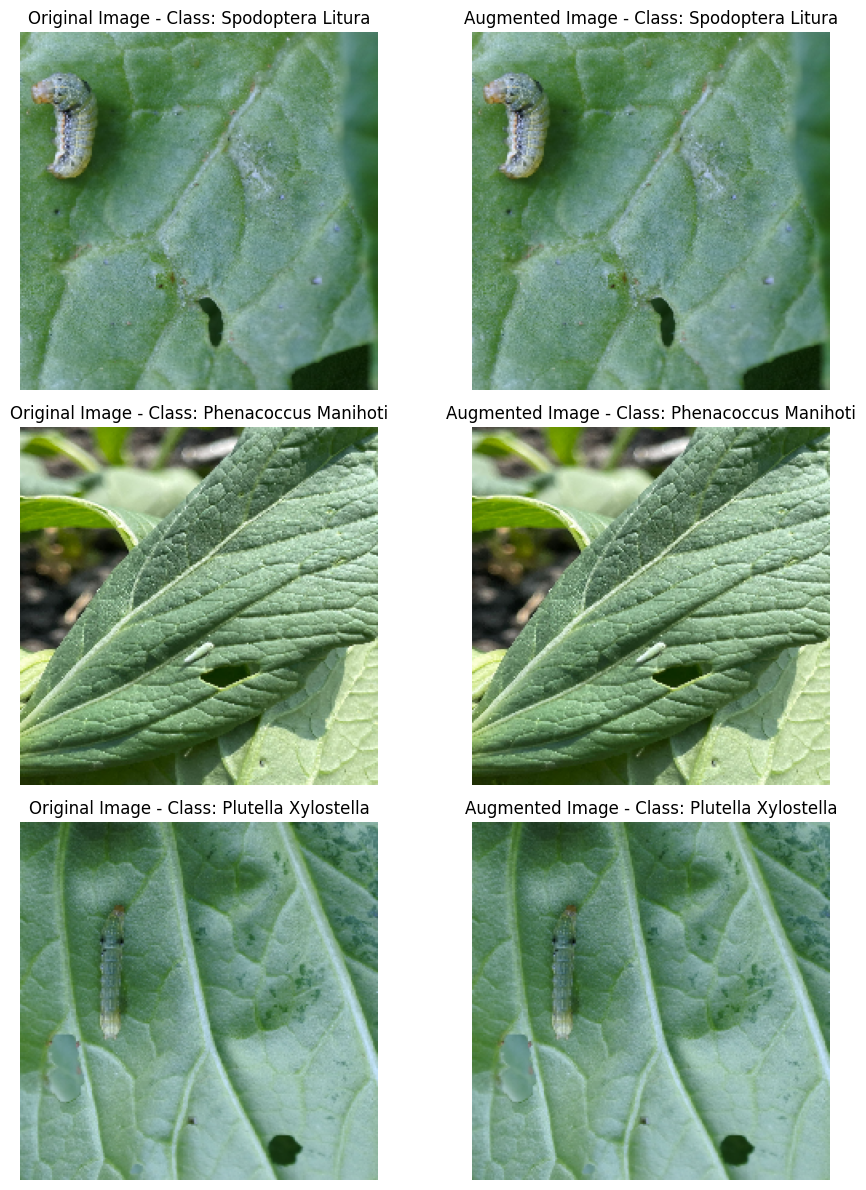

In [84]:
# Print class indices
print("Class Indices:")
for class_name, class_index in train_generator.class_indices.items():
    print(f"{class_index}: {class_name}")

# Reverse preprocessing for visualization
def reverse_preprocessing(img):
    img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0, 1]
    return img

# Create a dictionary to store one image per class
class_indices = {v: k for k, v in train_generator.class_indices.items()}
class_images = {}

# Fetch one image per class
for _ in range(len(train_generator)):
    img, label = next(train_generator)  # Use next() to fetch batch
    class_index = label.argmax()  # Find the class index
    class_name = class_indices[class_index]  # Map index to class name

    if class_name not in class_images:  # Store one image per class
        class_images[class_name] = img[0]
    if len(class_images) == len(class_indices):  # Stop when all classes are covered
        break

# Visualize original and augmented images
fig, axes = plt.subplots(len(class_images), 2, figsize=(10, len(class_images) * 4))

for i, (class_name, img) in enumerate(class_images.items()):
    # Display original image
    normalized_img = reverse_preprocessing(img)
    axes[i, 0].imshow(normalized_img)
    axes[i, 0].set_title(f"Original Image - Class: {class_name}")
    axes[i, 0].axis('off')

    # Apply augmentation manually
    augmented_img = datagen.random_transform(img)
    normalized_augmented_img = reverse_preprocessing(augmented_img)
    axes[i, 1].imshow(normalized_augmented_img)
    axes[i, 1].set_title(f"Augmented Image - Class: {class_name}")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [85]:
x_train, y_train = next(train_generator)  # Use next to get a batch
x_val, y_val = next(validation_generator)
print(f'Train batch shape: {x_train.shape}, Labels shape: {y_train.shape}')

print(f'Validation batch shape: {x_val.shape}, Labels shape: {y_val.shape}')

Train batch shape: (32, 224, 224, 3), Labels shape: (32, 4)
Validation batch shape: (0, 224, 224, 3), Labels shape: (0, 4)


#Train

In [86]:
# Build the model
model = Sequential()

# Add the pre-trained Xception model as the base model with a custom input shape
model.add(Xception(weights=None, include_top=False, pooling='avg', input_shape=(224, 224, 3)))

# Add custom layers
model.add(Dense(512))
model.add(Dense(64,activation='relu'))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(train_generator.num_classes, activation='softmax'))

# Freeze the base model
model.layers[0].trainable = False

# Compile the model with Adam optimizer
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print the model summary
model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 2048)                │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,943,660 (83.71 MB)

 Trainable params: 1,082,180 (4.13 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [87]:
history = model.fit(
    train_generator,                     # Training data
    validation_data=validation_generator, # Validation data
    epochs=5,                           # Number of epochs
    steps_per_epoch=len(train_generator), # Total batches in training dataset
    validation_steps=len(validation_generator), # Total batches in validation dataset
    verbose=1                            # Displays training progress
)




Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6693 - loss: 1.2987

ValueError: Must provide at least one structure

In [ ]:
score = model.evaluate(validation_generator, steps=validation_generator.samples // validation_generator.batch_size)
print(f'Validation loss: {score[0]}')
print(f'Validation accuracy: {score[1]}')


In [ ]:
# Evaluasi model
val_steps = validation_generator.samples // validation_generator.batch_size
predictions = model.predict(validation_generator, steps=val_steps)

# Ubah prediksi menjadi kelas numerik
y_pred = np.argmax(predictions, axis=1)
y_true = validation_generator.classes[:len(y_pred)]

# Confusion matrix dan laporan klasifikasi
conf_matrix = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=validation_generator.class_indices.keys(), output_dict=True)

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:
# model.save("/content/drive/MyDrive/Image-Dea/my_model_data.h5")
# try:
#     tfjs.converters.save_keras_model(model, "/content/drive/MyDrive/Image-Dea/tfjsv33")
#     print("Model successfully converted to TensorFlow.js format.")
# except Exception as e:
#     print("Failed to convert model to TensorFlow.js format:", e)

In [ ]:
# model = load_model('/content/drive/MyDrive/Image-Dea/my_model_data.h5')
# from tensorflow.keras.layers import InputLayer
# print(model.input_shape)

# print(model._layers[0])
# if not model.input_shape:
#   print('no')
# model._layers[0] = InputLayer(input_shape=(224, 224, 3))
# model.summary()
# Now you can proceed with the conversion
model.save('/content/drive/MyDrive/Image-Dea/new_model.keras')

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Assuming you already have train_generator and class_names defined
class_labels = train_generator.class_indices
class_names = {v: k for k, v in class_labels.items()}

# Load and preprocess the sample image
img_path = '/content/drive/MyDrive/Image-Dea/Dataset TA/Plutella Xylostella/1.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Apply preprocessing function defined in the ImageDataGenerator
img_array = datagen.preprocessing_function(img_array)  # Apply NASNet preprocessing

# Make a prediction
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)

# Get the class name for the predicted class index
predicted_class_name = class_names[predicted_class[0]]
print(f'Predicted class: {predicted_class_name}')
